# Prvi domaći zadatak iz predmeta 13E044DOS - Digitalna obrada slike
<hr>
<p style="font-size:20px">Viktor Todosijević 0050/2017</p>

## Prvi zadatak
<hr>

Automatsko numerisanje jednačina

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import ipywidgets as widgets

%matplotlib inline

from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))


### Učitavanje

In [3]:
imageio.plugins.freeimage.download()
img = imageio.imread('sekvence/sea.hdr',
                     format='HDR-FI')

### Rekreiranje slika sa gubicima u procentima

In [4]:
loss = [0, 0.001, 0.01]  # od 1
img_sat_array = {}  # dictionary
for i in range(len(loss)):
    img_sat_array[loss[i]] = np.array(img)  
    img_sat_array[loss[i]] /= np.amax(img_sat_array[loss[i]])
    
    img_flat_sort = img_sat_array[loss[i]].flatten()
    img_flat_sort.sort()  # trazimo zacrtani procenat

Sada kada smo sortirali niz možemo da zasitimo određeni procenat najvećih.

In [5]:
    index = round(-img_sat_array[loss[i]].size * loss[i] - 1)  # minus 1 zbog nule, da bi uzeo sa kraja a ne sa pocetka
    sat_max = img_flat_sort[np.int(index)]  # maks vrednost na osnovu gubitka
    img_sat_array[loss[i]][img_sat_array[loss[i]] > sat_max] = sat_max
    img_sat_array[loss[i]] = img_sat_array[loss[i]] / sat_max

Izvršimo gama korekciju.

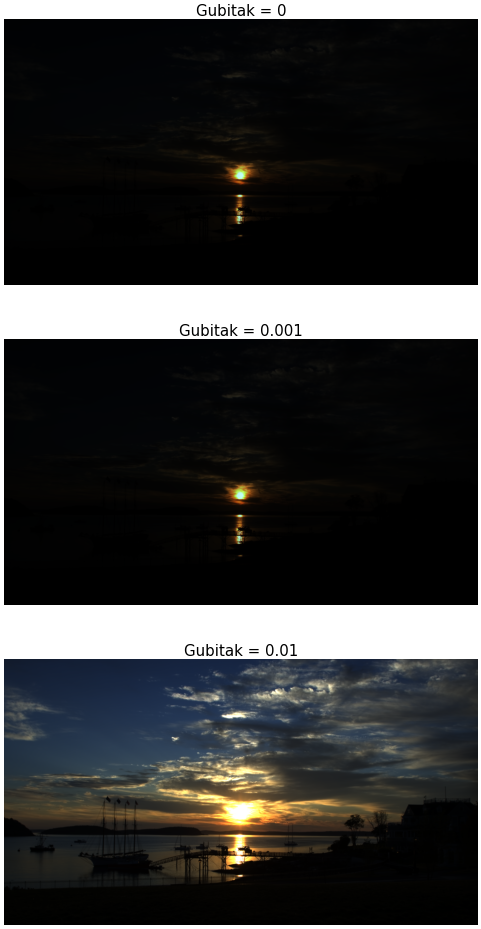

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(60,30), dpi=40);
gamma = 1.0

fontsize = 27
for i, chosen_loss in enumerate(loss):
    chosen_img = img_sat_array[chosen_loss]
    gamma_img = chosen_img ** (1/gamma)
    
    ax[i].imshow(gamma_img, vmin=np.amin(gamma_img), vmax=np.amax(gamma_img))
    ax[i].set_title("Gubitak = " + str(chosen_loss), fontsize=fontsize)
    ax[i].axis('off')


### A) Interaktivno traženje pojačanja A, B i C
Ispod je postojao slajder ali se u PDF-u izgubio.

In [7]:
# Interaktivno trazenje pojacanja
img_0_1 = img_sat_array[0]

In [8]:
def linear_map(A):
    
    # linearno skaliramo sliku pa izvršimo gama korekciju
    gamma = 2.2
    img_scaled = A * img_0_1
    gamma_img = img_scaled ** (1/gamma)
    gamma_img_clipped = np.clip(gamma_img, 0, 1)
    
    fig = plt.figure(figsize = (8, 6))
    plt.imshow(gamma_img_clipped)
    plt.title("Pojacanje = " + '%.2f' % A)
    plt.show()

In [9]:
widgets.interact(linear_map, A=widgets.FloatLogSlider(
    value=10,
    base=10,
    min=0, # max exponent of base
    max=2, # min exponent of base
    step=0.02, # exponent step
    ));

interactive(children=(FloatLogSlider(value=10.0, description='A', max=2.0, step=0.02), Output()), _dom_classes…

#### Rezultati linearnog skaliranja

In [10]:
A = 2.5 # mada moze biti +- 0.75
B = 17.5
C = 38
gain = [A, B, C]
gain_char = ["A", "B", "C"]

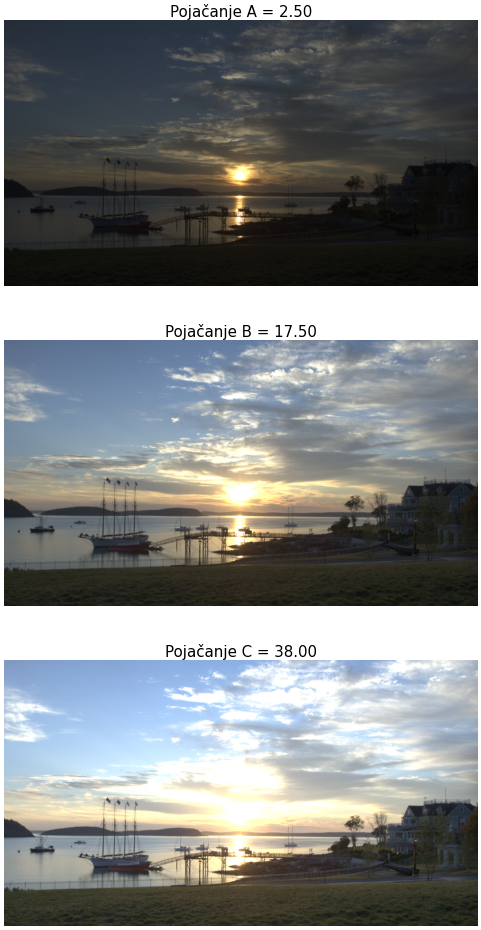

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(60,30), dpi=40);
img_0_1 = img_sat_array[0]
gamma = 2.2

for i in range(len(gain)):
    img_scaled = gain[i] * img_0_1
    gamma_img = img_scaled ** (1/gamma)
    gamma_img_clipped = np.clip(gamma_img, 0, 1)
    
    ax[i].imshow(gamma_img_clipped, vmin=np.amin(gamma_img), vmax=np.amax(gamma_img))
    ax[i].set_title("Pojačanje " + gain_char[i] + " = " + "%.2f" % gain[i], fontsize=fontsize)
    ax[i].axis('off')



### B) Transformacija logaritamskom i stepenom funkcijom

#### Logaritamska transformacija
\begin{equation}
y=c*log_b(1 + kx)
\end{equation}

\begin{equation}
c = \displaystyle\frac{1}{log_b(1 + k)}
\end{equation}


In [12]:
def log_base(base, x):
    return np.log(x) / np.log(base)

# c*log_b(1 + k*x)
# c*log_b(1 + k*1) = 1
# c = 1/log_b(1 + k)

base = 2 # base je zapravo nepotrebno jer imamo log_base(1 + kx) / log_base(1 + k) = log_1+k (1 + kx)
k = 100
c = 1 / log_base(base, 1 + k)
t = np.linspace(0, 1, 100)

#### Stepena transformacija
\begin{equation}
y = x^p
\end{equation}

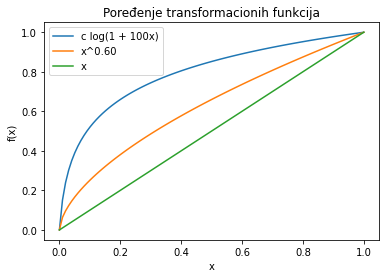

In [13]:
power = 0.6
plt.plot(t, c*log_base(base, 1 + k*t), label="c log(1 + " + "%d" % k + "x)")
plt.plot(t,t**power, label="x^" + "%.2f" % power)
plt.plot(t, t, label="x")

plt.title("Poređenje transformacionih funkcija")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()
    

Kao što se sa grafika može videti, obe transformacije daju više prostora na y osi pikselima sa manjim intenzitetom.

In [14]:
def log_scale(base, k, img, gamma):
    c = 1 / log_base(base, 1 + k)
    
    log_img = c*log_base(base, 1 + k*img)
    log_img_gamma = log_img **(1/gamma)
    return np.clip(log_img_gamma, 0, 1)

def power_scale(power, img, gamma):
    pow_img = img**power
    pow_img_gamma = pow_img**(1/gamma)
    return np.clip(pow_img_gamma, 0, 1)

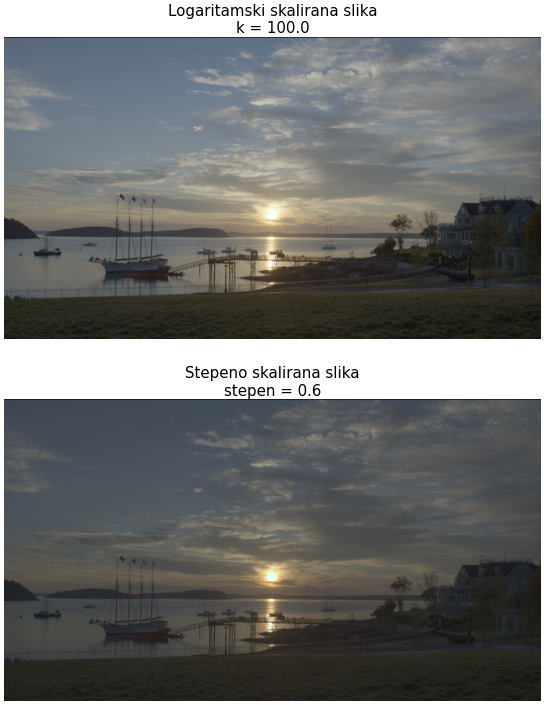

In [15]:
img_0_1 = img_sat_array[0]
gamma = 2.2
log_scaled_img = log_scale(base, k, img_0_1, gamma)
power_scaled_img = power_scale(power, img_0_1, gamma)

fig, ax = plt.subplots(2, 1, figsize=(32,22), dpi=40);

ax[0].imshow(log_scaled_img)
ax[0].set_title("Logaritamski skalirana slika\nk = " + "%.1f" % k, fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(power_scaled_img)
ax[1].set_title("Stepeno skalirana slika\nstepen = " + "%.1f" % power, fontsize=fontsize)
ax[1].axis('off')
plt.show()

### C) Neko drugo mapiranje
Ideja je da uradimo logaritamsku transformaciju pa da linearnim skaliranjem zasitimo najsvetlije piksele. Slika jeste malo svetlija ali ciljao sam da se vidi travnjak. Ako je fokus izlazak sunca onda ovo nije pravi izbor.

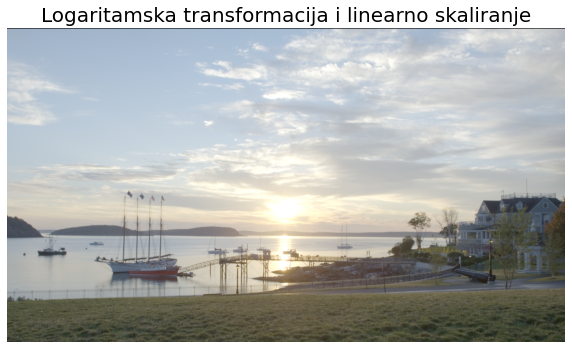

In [16]:
img_0_1 = img_sat_array[0]
k = 400
base = 2
gamma = 2.2


gain1 = 1.3
img_scaled_log = gain1 * log_scale(base, k, img_0_1, gamma)
clipped_img = np.clip(img_scaled_log, 0, 1)

plt.figure(figsize=(10,10))
plt.imshow(clipped_img)
plt.title("Logaritamska transformacija i linearno skaliranje", fontsize=20)
plt.axis('off')
plt.show()

Apdejtovanje numerisanja jednačina

In [17]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [18]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Drugi zadatak
<hr>

### Testiranje hipoteza

<p>Zadatak rešavamo na sledeći način - posmatrajmo piksele slike kao trodimenzionalne slučajne vektore sa matematičkim očekivanjem $M_x$ i kovarijacionom matricom $\Sigma_x$.</p>
<p> Za segmentaciju ćemo koristiti <b>test jedne hipoteze</b> i računaćemo statističko rastojanje dato sledećom formulom, poznato i kao Mahalanobis rastojanje: </p> 

\begin{equation}
d^2(X) =  (X - M_x) ^T \Sigma_x ^{-1} (X - M_x)
\end{equation}

<p>Pravilo odlučivanja testa jedne hipoteze onda glasi:</p>
\begin{equation}
d^2(X) < t \Rightarrow X \in \omega_1
\end{equation}

\begin{equation}
d^2(X) > t \Rightarrow X \in \Omega  \setminus  \omega_1
\end{equation}

<p>Gde je $t$ prag odlučivanja, $X \in \omega_1$ odluka da je $X$ u željenoj klasi, a $X \in \Omega  \setminus  \omega_1$ odluka da nije. </p>

In [19]:
from timeit import default_timer as timer

import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from matplotlib.patches import Rectangle
import cv2
import ipywidgets as widgets
from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Učitavanje

<p>Slike su učitane u RGB formatu. Nije bilo potrebe za promenom kolor sistema jer su rezultati bili zadovoljavajući u RGB sistemu.<br> </p>


In [20]:
marilyn = np.array(image.imread('sekvence/marlyn.jpg'))
umbrella = np.array(image.imread('sekvence/street.jpg'))

### Marilyn

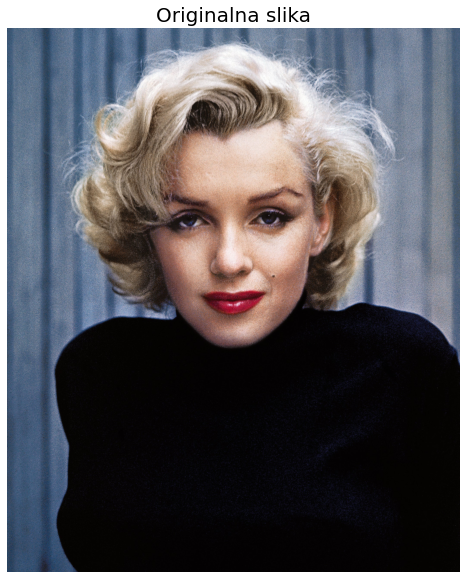

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(marilyn)
plt.title("Originalna slika", fontsize=20)
plt.axis('off')
plt.show()

In [22]:
closeup_rows = [1050, 1500]
closeup_columns = [700, 1250]

marilyn_close = np.array(marilyn[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])

datapoints_rows = [1230, 1320]
datapoints_columns = [970, 1070]

# sample - za segmentaciju ce nam biti potreban uzorak objekta koji zelimo da segmentisemo
marilyn_sample = np.array(marilyn[datapoints_rows[0]:datapoints_rows[1], datapoints_columns[0]:datapoints_columns[1], :])

#### Filtriranje
<br>
Filtriramo sliku od šuma za koji bih rekao da je impulsni pa koristimo median filtar i gledamo da sto više zamutimo detalje kao što je odsjaj usana kako bi usne ostale kao najdominantniji oblik. Filtriramo i uzorak ali sa manjom veličinom prozora filtra jer je i slika manja.

In [23]:
filter_name = 'median'

if filter_name == 'median':
    
    filt_size = 31

    filtered_closeup = cv2.medianBlur(marilyn_close, filt_size)
    filtered_img = cv2.medianBlur(marilyn, filt_size)
    
elif filter_name == 'bilateral':
    
    filt_size = 41
    sigma_s = filt_size/3
    sigma_r = 350
    filtered_closeup = cv2.bilateralFilter(marilyn_close, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s) 
    filtered_img = cv2.bilateralFilter(marilyn, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s) 
    


# ovde uzimamo median jer zelimo da ih smutimo vise ali uzimamo filtsize manji jer je slika manja
filt_size = 5
filtered_sample = cv2.medianBlur(marilyn_sample, filt_size)

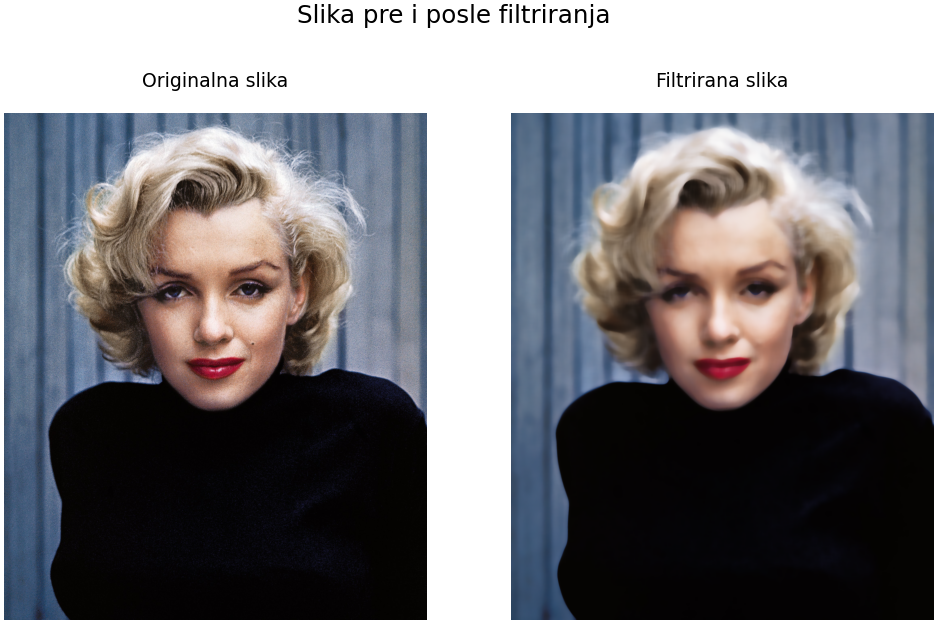

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(30,19), dpi=40);

fontsize = 34
suptitle_scale = 1.3

ax[0].imshow(marilyn)
ax[0].set_title("Originalna slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img)
ax[1].set_title("Filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Slika pre i posle filtriranja", fontsize= suptitle_scale * fontsize)
plt.show()

#### Poređenje

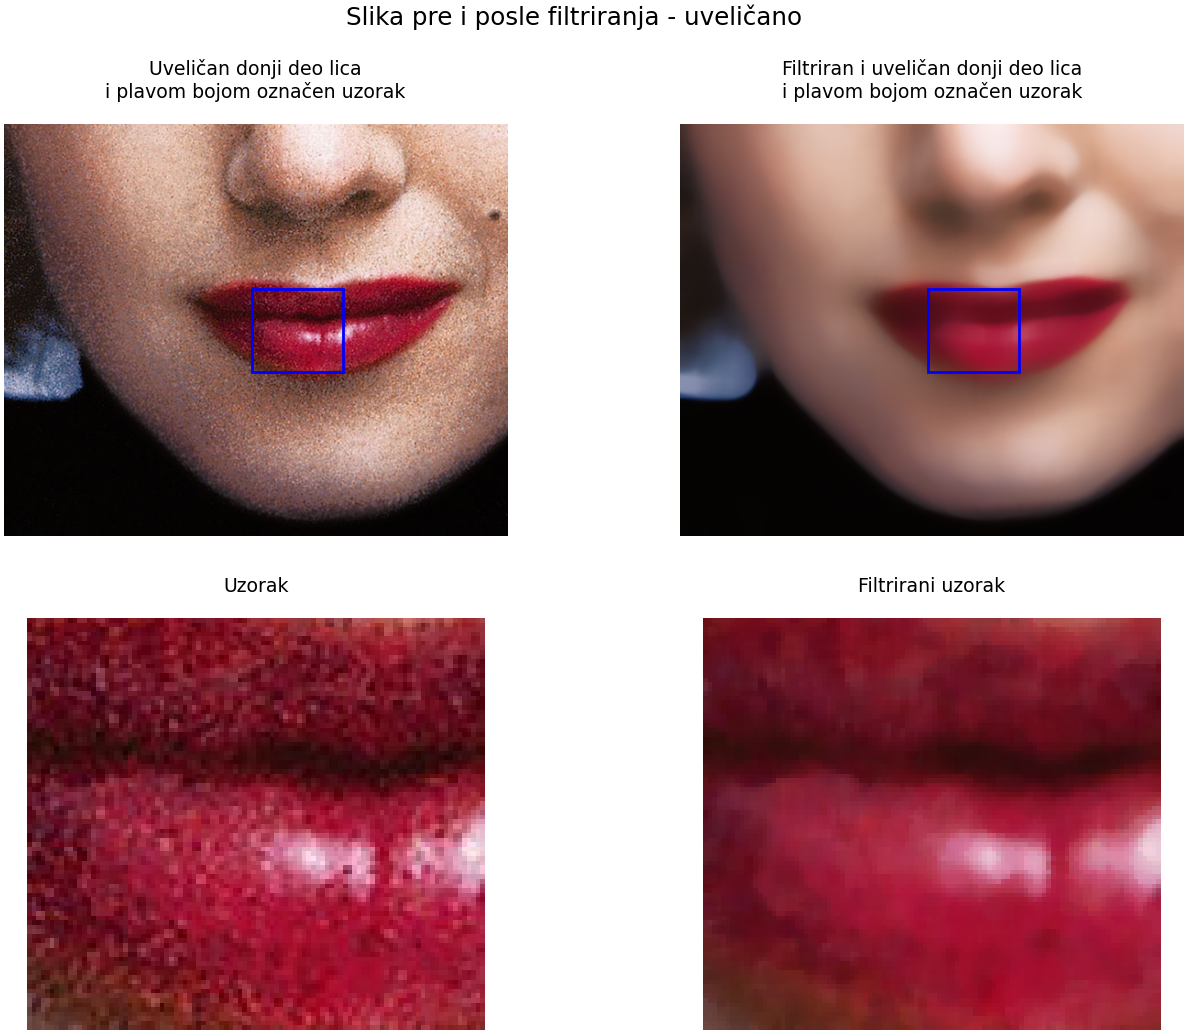

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(40,30), dpi=40);

# Nefiltrirano
# zumirano
ax[0, 0].imshow(marilyn_close)
ax[0, 0].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 0].set_title("Uveličan donji deo lica\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 0].axis('off')

# sample
ax[1, 0].imshow(marilyn_sample)
ax[1, 0].set_title("Uzorak\n", fontsize=fontsize)
ax[1, 0].axis('off')

# Filtrirano
# zumirano
ax[0, 1].imshow(filtered_closeup)
ax[0, 1].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 1].set_title("Filtriran i uveličan donji deo lica\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 1].axis('off')

# sample
ax[1, 1].imshow(filtered_sample)
ax[1, 1].set_title("Filtrirani uzorak\n", fontsize=fontsize)
ax[1, 1].axis('off')

fig.suptitle("Slika pre i posle filtriranja - uveličano", fontsize= suptitle_scale * fontsize)
plt.show()

#### Statistički parametri uzorka

In [26]:
X = filtered_sample.reshape((filtered_sample.shape[0] * filtered_sample.shape[1], 3)).T

sigma = np.cov(X)
M = np.mean(X, 1)
sigma_inv = np.linalg.inv(sigma)

# Prag odlučivanja
threshold = 5.5


#### Matrica statističkih rastojanja
<br>
<p>Za svaki piksel odredimo statističko odstojanje od uzorka i na osnovu njega kasnije donosimo odluku.</p>

In [27]:
def distance_einsum(Y, sigma_inv, M):
    Z = Y - M
    W = np.einsum("ijk,kl->ijl", Z, sigma_inv)
    d = np.einsum("ijk,ijk->ij", W, Z)
    return d

start = timer()
dist = distance_einsum(filtered_img, sigma_inv, M)
end = timer()
print("%.3f" % (end - start), " sec Vreme računanja rastojanja")

0.298  sec Vreme računanja rastojanja


#### Ilustracija metode
<br>
Delovi slike koji su tamniji imaju veće statističko rastojanje i verovatnije su deo traženog segmenta.

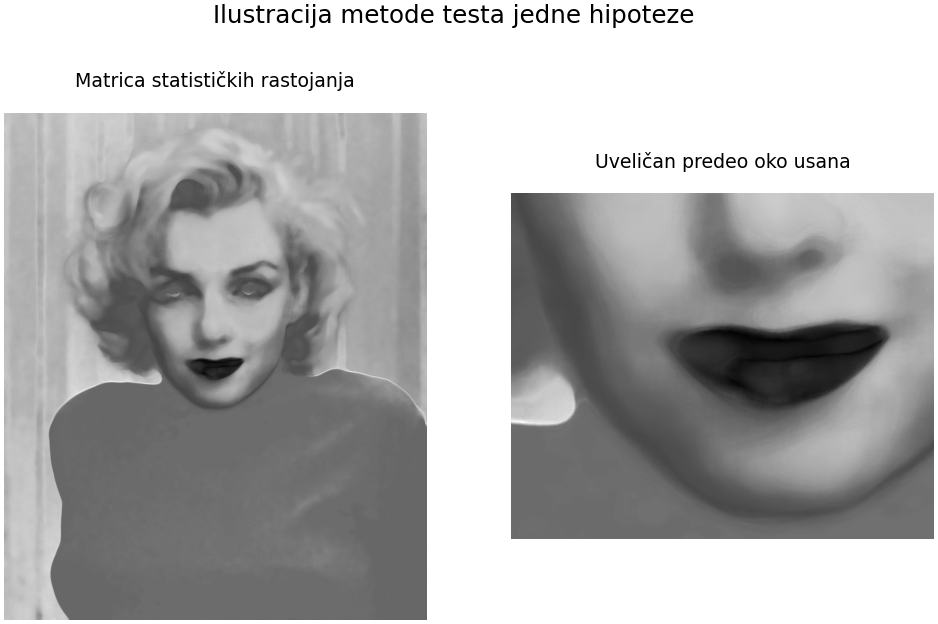

In [28]:
dist_img = dist / np.amax(dist)

# gama korekcija čisto da se bolje vidi
gamma = 2.4
dist_img = dist_img ** (1 / gamma)

fig, ax = plt.subplots(1, 2, figsize=(30,19), dpi=40);

ax[0].imshow(dist_img, cmap="gray")
ax[0].set_title("Matrica statističkih rastojanja\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(dist_img[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1]], cmap="gray")
ax[1].set_title("Uveličan predeo oko usana\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Ilustracija metode testa jedne hipoteze", fontsize= suptitle_scale * fontsize)
plt.show()

In [29]:
def gray_copy(original):
    gray = rgb2gray(original)
    gray = gray * 255
    gray = gray.astype(int)
    return gray

#### Segmentacija

In [30]:
filtered_img_segmented = np.array(filtered_img)
unfiltered_img_segmented = np.array(marilyn)

start = timer()

gray_filtered_3_channels = np.tile(gray_copy(filtered_img)[dist > threshold], (3, 1)).T

filtered_img_segmented[dist > threshold] = gray_filtered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na filtriranu sliku")

start = timer()

gray_unfiltered_3_channels = np.tile(gray_copy(unfiltered_img_segmented)[dist > threshold], (3, 1)).T
unfiltered_img_segmented[dist > threshold] = gray_unfiltered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na nefiltriranu sliku")

0.271  sec Vreme primene maske na filtriranu sliku
0.248  sec Vreme primene maske na nefiltriranu sliku


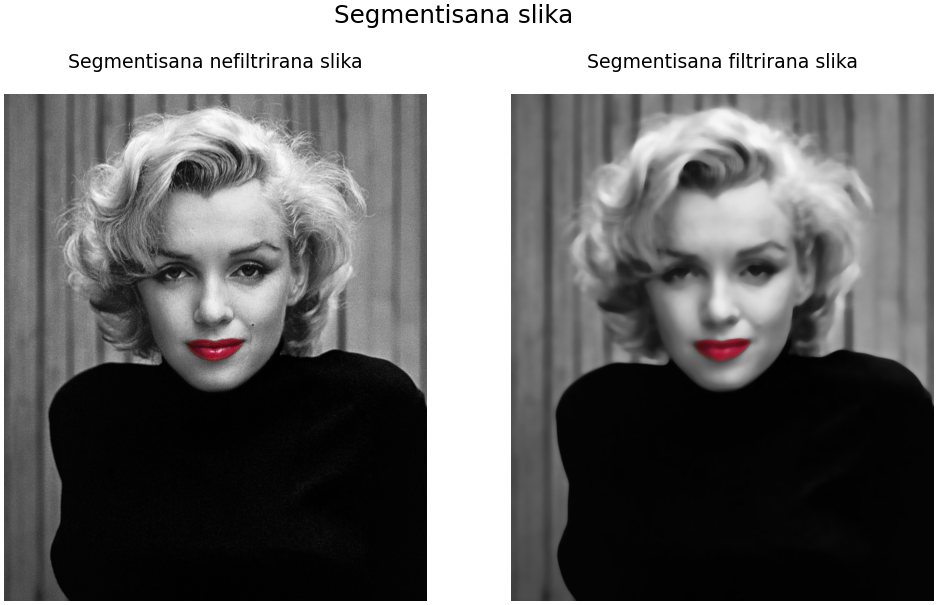

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(30,18), dpi=40);


ax[0].imshow(unfiltered_img_segmented)
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented)
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

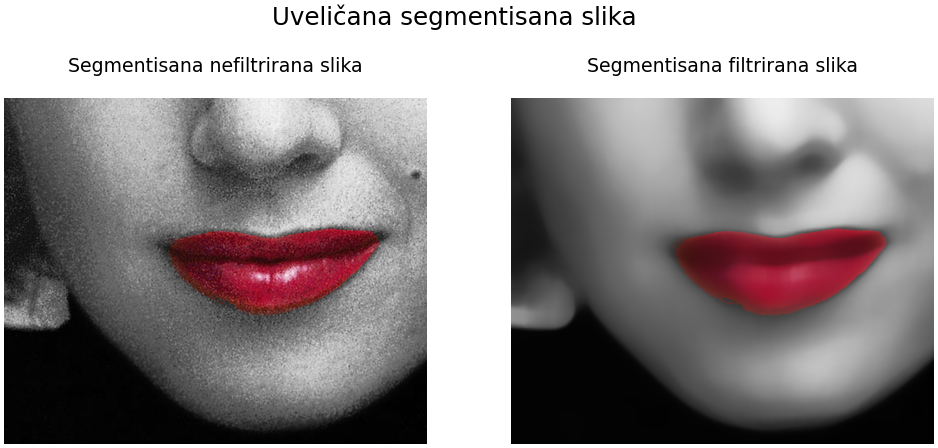

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(30,14), dpi=40);

ax[0].imshow(unfiltered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Uveličana segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

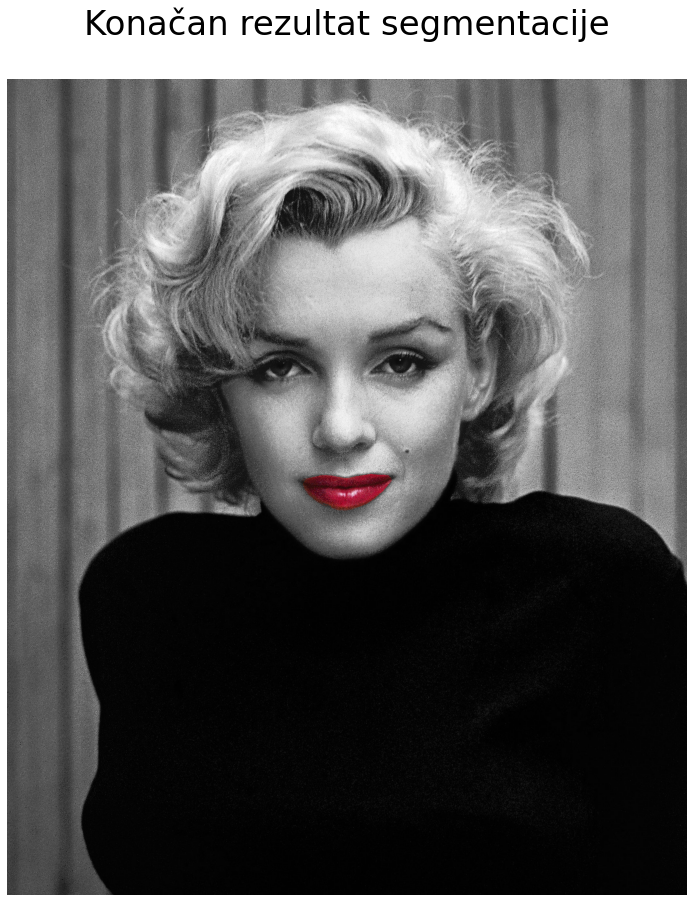

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(unfiltered_img_segmented)
plt.title("Konačan rezultat segmentacije\n", fontsize=fontsize)
plt.axis('off')
plt.show()

### Kišobran

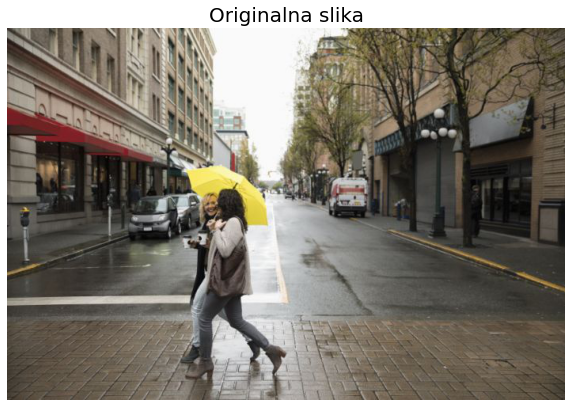

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(umbrella)
plt.title("Originalna slika", fontsize=20)
plt.axis('off')
plt.show()

In [35]:
closeup_rows = [170, 260]
closeup_columns = [210, 335]

umbrella_close = np.array(umbrella[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])

datapoints_rows = [180, 200]
datapoints_columns = [250, 280]

# sample - za segmentaciju ce nam biti potreban uzorak objekta koji zelimo da segmentisemo
umbrella_sample = np.array(umbrella[datapoints_rows[0]:datapoints_rows[1], datapoints_columns[0]:datapoints_columns[1], :])

#### Filtriranje
Za ovu sliku iskorišćen je bilateralni filtar zbog potrebe da se očuvaju ivice kišobrana.

In [36]:
filter_name = 'bilateral'

if filter_name == 'median':
    
    filt_size = 19

    filtered_closeup = cv2.medianBlur(umbrella_close, filt_size)
    filtered_img = cv2.medianBlur(umbrella, filt_size)
    
elif filter_name == 'bilateral':
    
    filt_size = 21
    sigma_s = 5
    sigma_r = 90
    filtered_closeup = cv2.bilateralFilter(umbrella_close, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s)
    umbrella_double = umbrella.astype(np.double) / 255.0
    filtered_img = cv2.bilateralFilter(umbrella, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s) 
    


# ovde uzimamo median jer zelimo da ih smutimo vise ali uzimamo filtsize manji jer je slika manja
filt_size = 5
filtered_sample = cv2.medianBlur(umbrella_sample, filt_size)

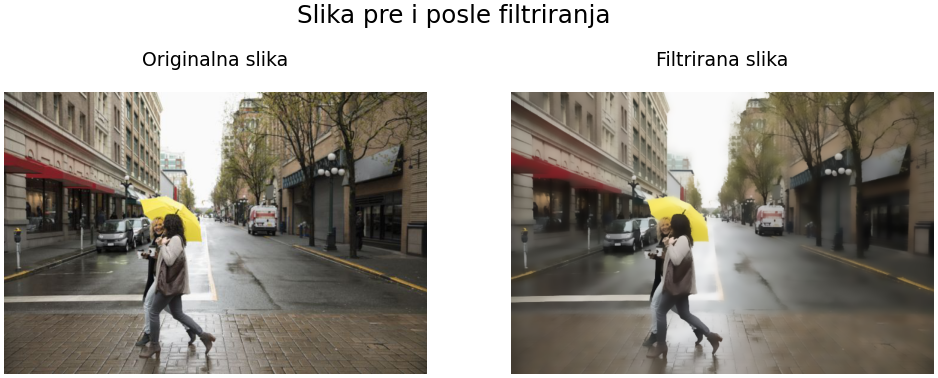

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(30,12), dpi=40);

fontsize = 34
suptitle_scale = 1.3

ax[0].imshow(umbrella)
ax[0].set_title("Originalna slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img)
ax[1].set_title("Filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Slika pre i posle filtriranja", fontsize= suptitle_scale * fontsize)
plt.show()

#### Poređenje

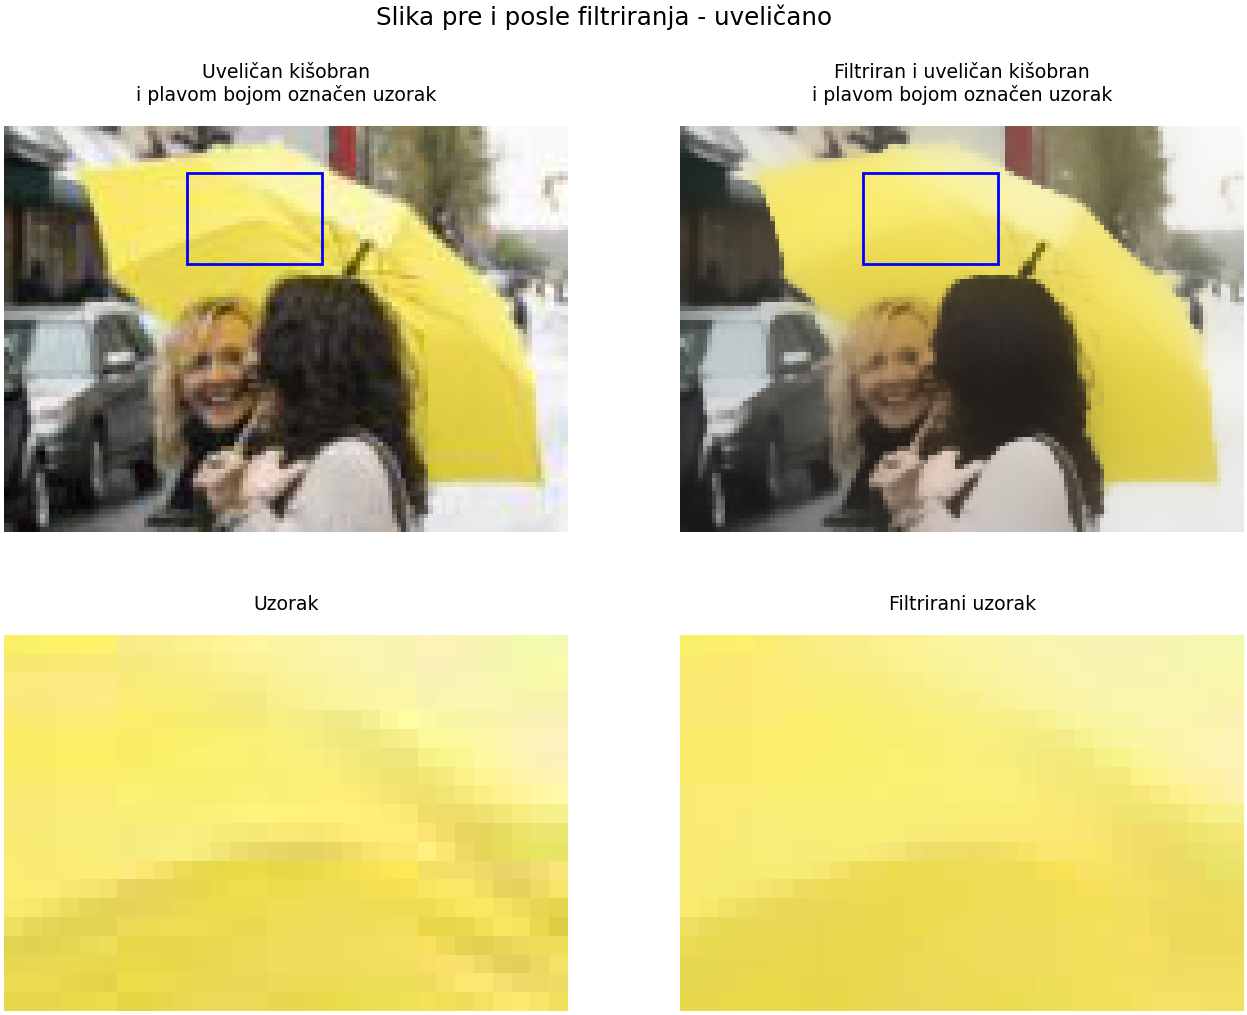

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(40,30), dpi=40);

# Nefiltrirano
# zumirano
ax[0, 0].imshow(umbrella_close)
ax[0, 0].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 0].set_title("Uveličan kišobran\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 0].axis('off')

# sample
ax[1, 0].imshow(umbrella_sample)
ax[1, 0].set_title("Uzorak\n", fontsize=fontsize)
ax[1, 0].axis('off')

# Filtrirano
# zumirano
ax[0, 1].imshow(filtered_closeup)
ax[0, 1].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 1].set_title("Filtriran i uveličan kišobran\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 1].axis('off')

# sample
ax[1, 1].imshow(filtered_sample)
ax[1, 1].set_title("Filtrirani uzorak\n", fontsize=fontsize)
ax[1, 1].axis('off')

fig.suptitle("Slika pre i posle filtriranja - uveličano", fontsize= suptitle_scale * fontsize)
plt.show()

#### Statistički parametri uzorka

In [39]:
X = filtered_sample.reshape((filtered_sample.shape[0] * filtered_sample.shape[1], 3)).T

sigma = np.cov(X)
M = np.mean(X, 1)
sigma_inv = np.linalg.inv(sigma)

# Prag odlučivanja
threshold = 60

#### Matrica statističkih rastojanja

In [40]:
start = timer()
dist = distance_einsum(filtered_img, sigma_inv, M)
end = timer()
print("%.3f" % (end - start), " sec Vreme računanja rastojanja")

0.025  sec Vreme računanja rastojanja


#### Ilustracija metode
Delovi slike koji su tamniji imaju veće statističko rastojanje i verovatnije su deo traženog segmenta.

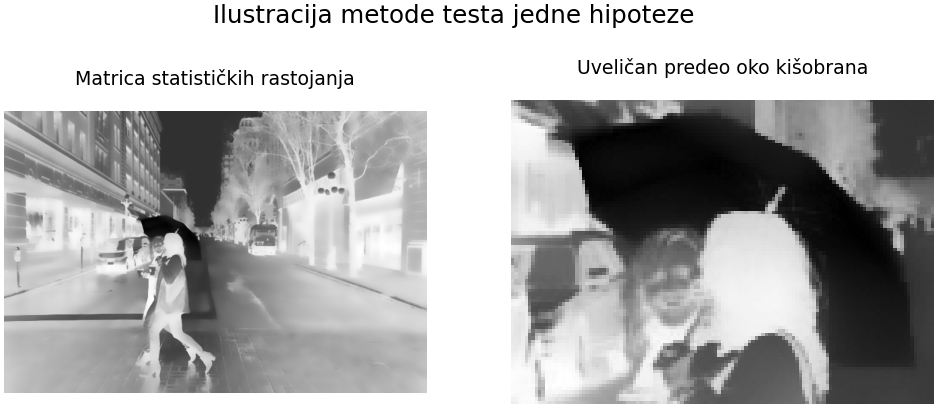

In [41]:
dist_img = dist / np.amax(dist)

# gama korekcija čisto da se bolje vidi
gamma = 2.4
dist_img = dist_img ** (1 / gamma)

fig, ax = plt.subplots(1, 2, figsize=(30,13), dpi=40);

ax[0].imshow(dist_img, cmap="gray")
ax[0].set_title("Matrica statističkih rastojanja\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(dist_img[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1]], cmap="gray")
ax[1].set_title("Uveličan predeo oko kišobrana\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Ilustracija metode testa jedne hipoteze", fontsize= suptitle_scale * fontsize)
plt.show()

#### Segmentacija

In [42]:
filtered_img_segmented = np.array(filtered_img)
unfiltered_img_segmented = np.array(umbrella)

start = timer()

gray_filtered_3_channels = np.tile(gray_copy(filtered_img)[dist > threshold], (3, 1)).T

filtered_img_segmented[dist > threshold] = gray_filtered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na filtriranu sliku")

start = timer()

gray_unfiltered_3_channels = np.tile(gray_copy(unfiltered_img_segmented)[dist > threshold], (3, 1)).T
unfiltered_img_segmented[dist > threshold] = gray_unfiltered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na nefiltriranu sliku")

0.031  sec Vreme primene maske na filtriranu sliku
0.022  sec Vreme primene maske na nefiltriranu sliku


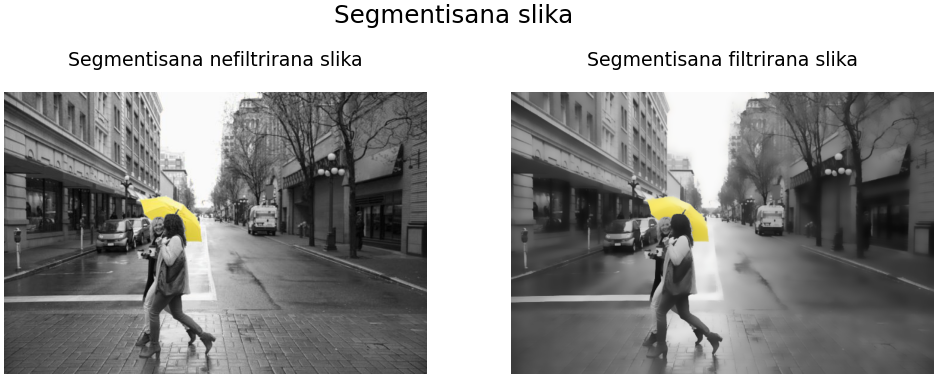

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(30,12), dpi=40);


ax[0].imshow(unfiltered_img_segmented)
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented)
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

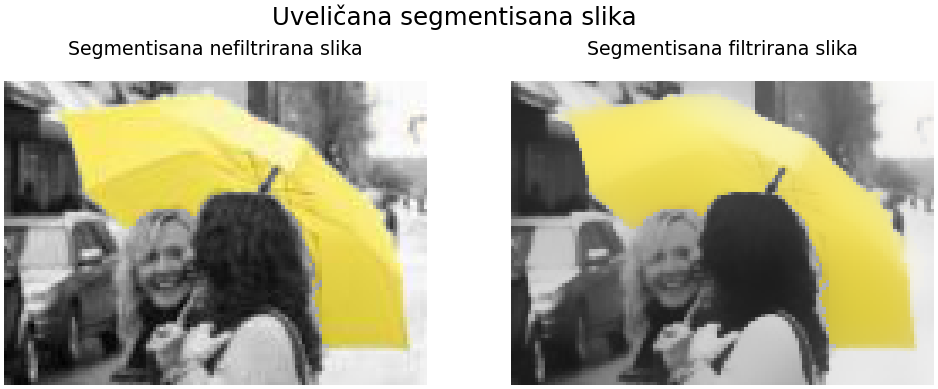

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(30,12), dpi=40);

ax[0].imshow(unfiltered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Uveličana segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

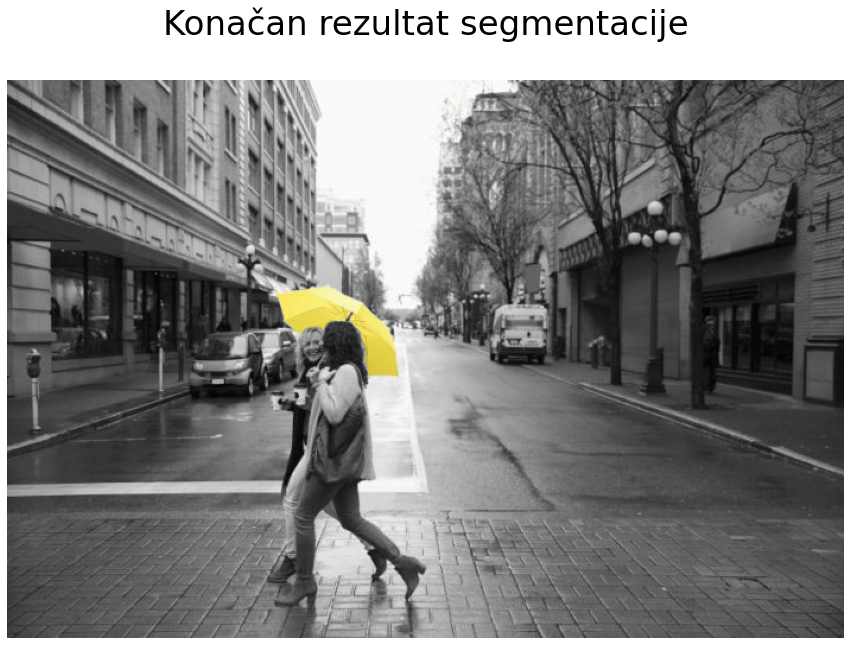

In [45]:
plt.figure(figsize=(15,15))
plt.imshow(unfiltered_img_segmented)
plt.title("Konačan rezultat segmentacije\n", fontsize=fontsize)
plt.axis('off')

plt.show()

In [46]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [47]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Treći zadatak
<hr>

### Bilateralni filtar
<hr>
<p>Bilateralni filtar je filtar čija težinska funkcija zavisi, ne samo od pozicije u prozoru, već i od vrednosti piksela obuhvaćenih prozorom. Kako težinska funkcija zavisi od položaja u slici, bilateralni filtar je komplikovaniji za izračunavanje.</p>

<p>Težinska funkcija bilateralnog filtra data je sledećom formulom:</p>


\begin{equation}
w[k,l] = e^{-\displaystyle\frac{k^2 + l^2}{2\sigma_s^2}} e^{-\displaystyle\frac{(x[m + k, n + l] - x[m, n])^2}{2\sigma_r^2}} 
\end{equation}

<br>
$$ k, l \in [-r, r]$$
$$m \in [0, M - 1]$$
$$n \in [0, N - 1]$$


<p>Gde je $r$ radijus maske, $M$ i $N$ dimenzije slike, $k$ i $l$ prostorne koordinate unutar prozora, $m$ i $n$ koordinate piksela u slici, a $\sigma_s$ i $\sigma_r$ parametri filtra</p>

<p>Ideja bilateralnog filtra je da zamućuje sliku ali da detektuje ivice u slici i tada selektivno zamuti samo jednu stranu ivice, samim tim ih čuvajući.</p>


In [48]:
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.restoration import denoise_bilateral
from numpy.lib.stride_tricks import as_strided
from timeit import default_timer as timer
from IPython.display import display, HTML

out = display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [49]:
# konverzija slike u sivu
def gray_copy(original):
    gray = rgb2gray(original)
    gray = gray * 255
    gray = gray.astype(np.uint8)
    return gray

# smisliti kako ovo objasniti
def make_4d_array(arr_padded, r):
    N = arr_padded.shape[0] - 2 * r
    M = arr_padded.shape[1] - 2 * r

    # vracamo view na niz, samo ne kapiram zasto puta 2 strides
    return as_strided(arr_padded, shape=(N, M, 2 * r + 1, 2 * r + 1), strides=arr_padded.strides * 2)

# gausov prozor, ne zavisi od pozicije u slici
def spatial_kernel(r, sigma_s):
    A = np.arange(-r, r + 1)
    A = np.einsum("i,i->i", A, A)
    return np.exp(-(np.tile(A, (2 * r + 1, 1)) + np.tile(A, (2 * r + 1, 1)).T) / (2 * sigma_s ** 2))


### Učitavanje
Učitavamo sliku i pretvaramo je u sivu sliku.

In [50]:
my_image = np.array(image.imread('sekvence/nice.jpg'))
img = gray_copy(my_image)

### Algoritam
* Funkcija prvo izvrši proveru ispravnosti ulaznih podataka. Ako ulazni podaci nisu odgovarajućeg tipa podiže se izuzetak.
<p><br></p>
* Ulazna slika se proširuje za r piksela sa svake strane kopiranjem ivica
<p><br></p>

* Od slike napravimo 4D niz koji možemo da zamislimo kao tablu za Sudoku. Ovo radimo jednom kako ne bismo morali da pronalazimo okolne piksele za svaki piksel originalne slike tokom iteracije već to uradimo jednom na početku. Iako je 4D slika dimenzija N x M x (2r + 1) x (2r + 1), ona ne zauzima značajnu dodatnu memoriju jer je uz pomoć funkcije _as_strided_ dobijamo kao _view_ odnosno _pogled_ na originalnu sliku. Ova ušteda u memoriji dolazi sa ograničenjem da takvu sliku onda ne možemo menjati, ne možemo upisivati vrednosti u nju (tehnički možemo, ali rezultati neće biti smisleni).

<!-- <img src="sudoku.png" alt="Sudoku"> -->
![Drag Racing](image/sudoku.png)
<p style="text-align:center;">Sudoku tabla - u htmlu je slika bila centrirana<br></p>

<p>Svaka podtabla (podslika, 2D slika) u glavnoj tabli za sudoku predstavlja prozor originalne slike nad kojim se radi filtriranje, a svaka sledeća podtabla predstavlja taj prozor pomeren za jedan red ili kolonu kao na sledećem primeru:</p>

<!-- <img src="image/filt_gif.gif" alt="Filtriranje"> -->
![Alt Text](image/filt_img.png)


<p style="text-align:center;">Filtriranje - u html je bilo .gif centriran, u PDF-u je slika<br></p>

* Iteriramo kroz svaku podsliku, računamo težinsku funkciju za svaku od njih i kao novi piksel filtrirane slike na toj poziciji vratimo korelaciju podslike i težinske funkcije. Korelacija se vrši funkcijom np.einsum, koja menja dvostruku for petlju kroz prozor, radi bržeg izvršavanja programa.


* Sva izračunavanja se obavljaju nad brojevima u pokretnom zarezu pa je na kraju potrebno pretvoriti sliku u originalni format.

In [51]:
def bilateral_filter(img, r, sigma_s, sigma_r):
    
    
    # Provere tipa i skaliranje
    if img.dtype == np.uint8:
        
        img_double = img.astype(np.double) / 255.0

    elif img.dtype == np.double:
        img_double = img
    else:
        raise TypeError("Slika mora biti tipa uint8 ili double\nSlika koje je prosledjena je tipa:\t" + str(img.dtype))
        
    
    
    # padding
    # prosiriti sliku sa po r piksela sa ivice
    padded_img = np.pad(img_double, [r, r], mode="edge")
    
    # 4d slika
    img_4d = make_4d_array(padded_img, r)

    # novi niz
    filtered_img = np.zeros_like(img_double)

    # prostorni kernel
    ws = spatial_kernel(r, sigma_s)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            wr = np.exp(-((img_4d[i, j] - img_4d[i, j, r, r]) ** 2) / (2 * sigma_r ** 2))
            W = wr * ws  # element-wise
            W = W / np.sum(W)  # normalizacija

            # korelacija
            filtered_img[i, j] = np.einsum('ij, ij->', img_4d[i, j], W)
            
    if img.dtype == np.uint8:
        
        filtered_img *= 255.0
        return filtered_img.astype(np.uint8)

    elif img.dtype == np.double:
        return filtered_img
    else:
        raise TypeError("Slika mora biti tipa uint8 ili double\nSlika koje je prosledjena je tipa:\t" + str(img.dtype))

### Brzina izvršavanja i poređenje

In [52]:
r = [2, 4, 20, 40, 80]
sigma_s = 10
sigma_r = 0.1

filtered_img_viktor = []
t_viktor = []

filtered_img_scikit = []
t_scikit = []


for i in range(len(r)):
    # viktor
    start = timer()

    filtered_img_viktor.append(bilateral_filter(img, r[i], sigma_s, sigma_r))
    
    end = timer()
    t_viktor.append(end - start)
    
    # scikit
    img_double = img.astype(np.double) / 255.0 
    start = timer()

    filtered_img_scikit.append(denoise_bilateral(img_double, win_size=2*r[i] + 1, sigma_color=sigma_r, sigma_spatial=sigma_s))
    
    end = timer()
    t_scikit.append(end - start)

r [pix] 	t_Viktor [s] 		t_scikit [s]
------------------------------------------------------------------
2 		5.065	 		0.074	
4 		5.351	 		0.213	
20 		9.795	 		4.370	
40 		22.215	 		16.806	
80 		68.224	 		66.440	

r [pix] 	t_Viktor [us/pix] 	t_scikit [us/pix]
------------------------------------------------------------------
2 		21.981	 		0.323	
4 		23.224	 		0.926	
20 		42.512	 		18.967	
40 		96.418	 		72.945	
80 		296.113	 		288.367	


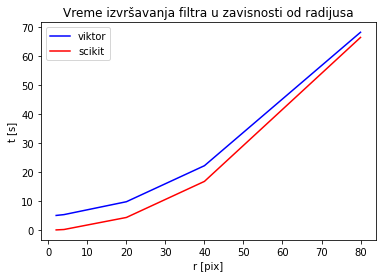

In [53]:
pix_num = img.shape[0] * img.shape[1]

print("r [pix]", "\tt_Viktor [s]", "\t\tt_scikit [s]")
print("------------------------------------------------------------------")
for i in range(len(r)):
    print(r[i], "\t\t%.3f\t" % t_viktor[i], "\t\t%.3f\t" % t_scikit[i])

print("\nr [pix]","\tt_Viktor [us/pix]", "\tt_scikit [us/pix]")
print("------------------------------------------------------------------")

for i in range(len(r)):
    print(r[i], "\t\t%.3f\t" % (t_viktor[i]/pix_num*1e6), "\t\t%.3f\t" % (t_scikit[i]/pix_num*1e6))


plt.plot(r, t_viktor, color='b', label='viktor')
plt.plot(r, t_scikit, color='r', label='scikit')
plt.ylabel("t [s]")
plt.xlabel("r [pix]")
plt.title("Vreme izvršavanja filtra u zavisnosti od radijusa")
plt.legend()
plt.show()

Možemo primetiti da su obe funkcije vremenske složenosti $\mathcal{O}(r^2)$, ali da moja ima odredjene konstantne vremenske troškove veće od ugrađenog.

Razmotrimo sada učinak filtra za različite vrednosti parametara.

### Promena parametara

#### Promena $\sigma_r$

In [54]:
r = 10
sigma_s = 7
sigma_r = [0.1, 0.5, 0.9]

filtered_img = []

for i in range(len(sigma_r)):
    filtered_img.append(bilateral_filter(img, r, sigma_s, sigma_r[i]))                        

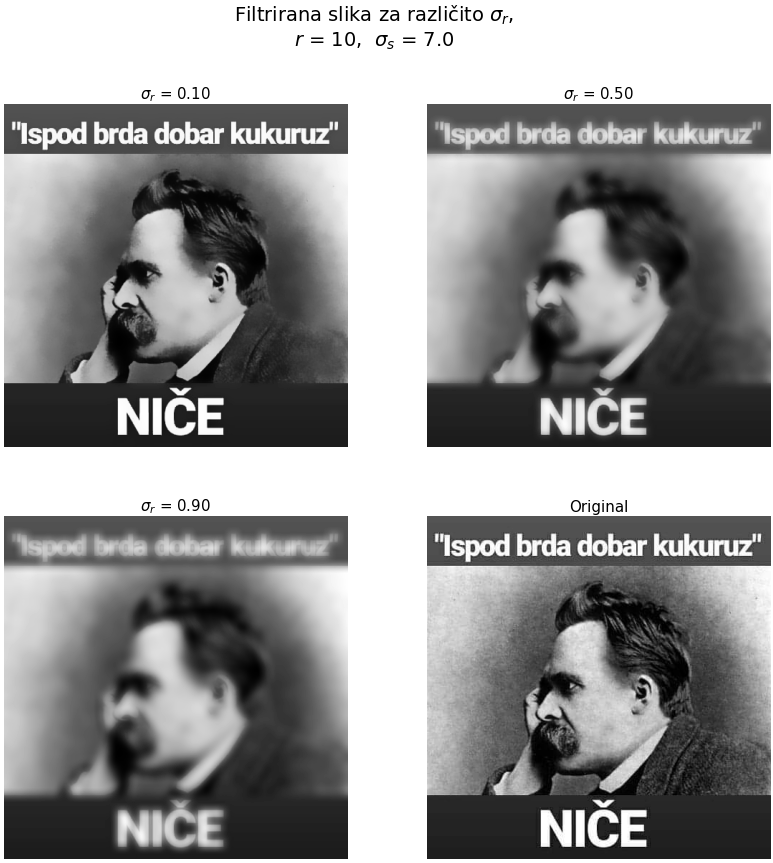

In [55]:
fontsize = 27
fig, ax = plt.subplots(2, 2, figsize=(25,25), dpi=40);

for i in range(len(sigma_r)):
    ax[i // 2, i % 2].imshow(filtered_img[i], cmap="gray")
    ax[i // 2, i % 2].set_title("$\sigma_r$ = " + "%.2f" % sigma_r[i], fontsize=fontsize)
    ax[i // 2, i % 2].axis('off')


ax[1, 1].imshow(img, cmap="gray")
ax[1, 1].set_title("Original", fontsize=fontsize)
ax[1, 1].axis('off')
fig.suptitle("Filtrirana slika za različito $\sigma_r$,\n$r$ = " + "%d, " % r + " $\sigma_s$ = " + "%.1f" % sigma_s, fontsize=1.3*fontsize)
plt.show()

Možemo primetiti da kako povećavamo $\sigma_r$ tako član težinske finkcije sa $\sigma_r$ ima manje efekta i tada filtar sve više liči na običan Gausov.

#### Promena $\sigma_s$

In [56]:
r = 10
sigma_s = [1, 10, 20]
sigma_r = 0.1

filtered_img = []

for i in range(len(sigma_s)):
    filtered_img.append(bilateral_filter(img, r, sigma_s[i], sigma_r))     

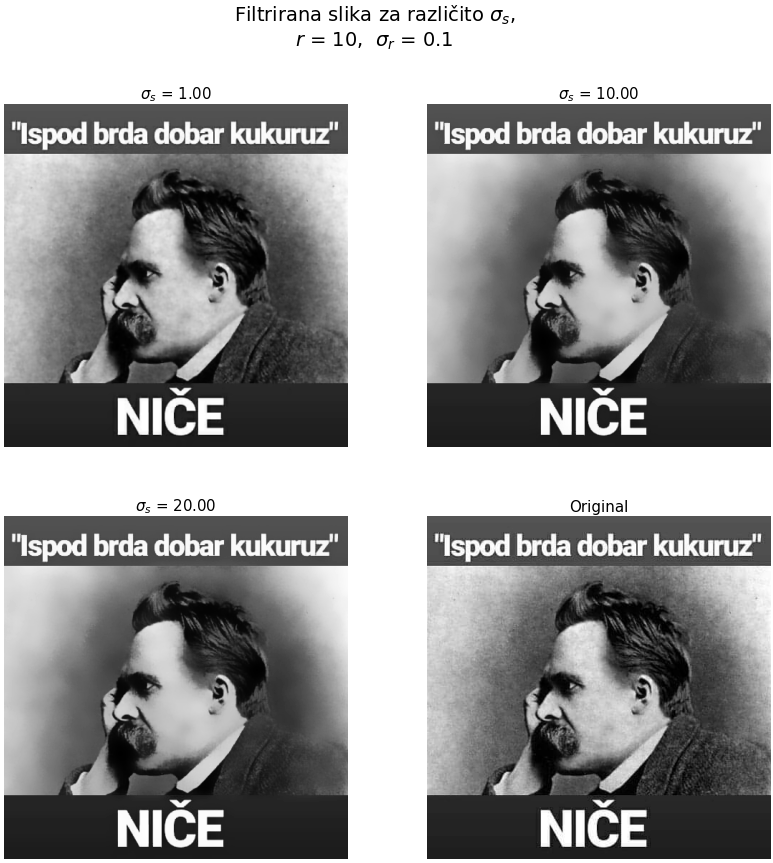

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(25,25), dpi=40);

for i in range(len(sigma_s)):
    ax[i // 2, i % 2].imshow(filtered_img[i], cmap="gray")
    ax[i // 2, i % 2].set_title("$\sigma_s$ = " + "%.2f" % sigma_s[i], fontsize=fontsize)
    ax[i // 2, i % 2].axis('off')

ax[1, 1].imshow(img, cmap="gray")
ax[1, 1].set_title("Original", fontsize=fontsize)
ax[1, 1].axis('off')
fig.suptitle("Filtrirana slika za različito $\sigma_s$,\n$r$ = " + "%d, " % r + " $\sigma_r$ = " + "%.1f" % sigma_r, fontsize=1.3*fontsize)
plt.show()

Kako povećavamo $\sigma_s$ tako dajemo veću težinu pikselima udaljenim od centralnog i intenzitet je sve uniformniji. Ali pošto smo odabrali odgovarajuće $\sigma_r$ ivice su i dalje očuvane.

#### Promena $r$

In [58]:
r = [2, 10, 40]
sigma_s = 10
sigma_r = 0.1

filtered_img = []

for i in range(len(r)):
    filtered_img.append(bilateral_filter(img, r[i], sigma_s, sigma_r))

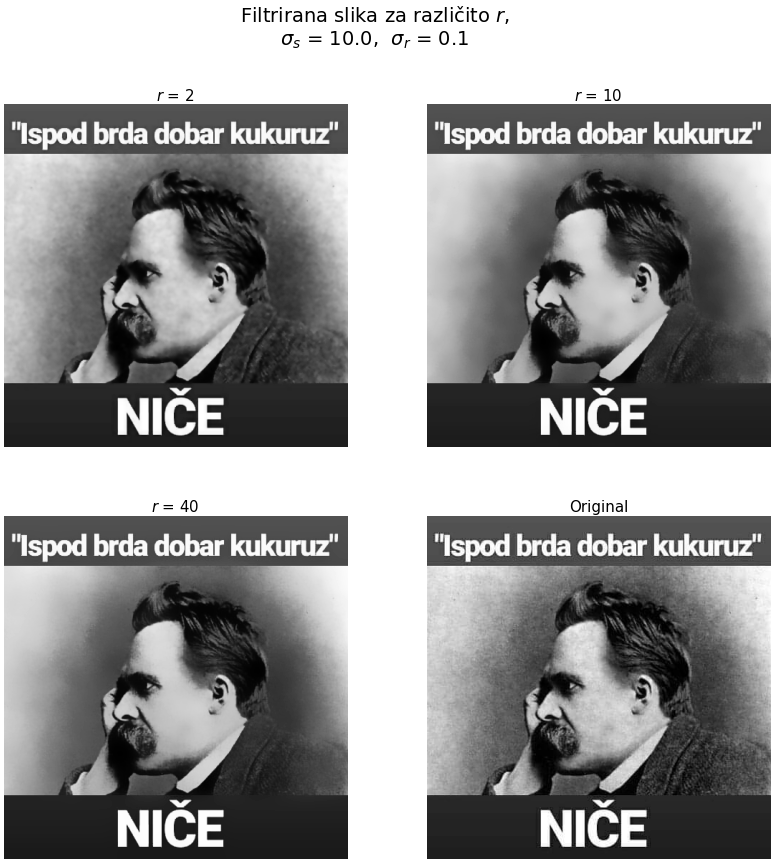

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(25,25), dpi=40);

for i in range(len(r)):
    ax[i // 2, i % 2].imshow(filtered_img[i], cmap="gray")
    ax[i // 2, i % 2].set_title("$r$ = " + "%d" % r[i], fontsize=fontsize)
    ax[i // 2, i % 2].axis('off')

ax[1, 1].imshow(img, cmap="gray")
ax[1, 1].set_title("Original", fontsize=fontsize)
ax[1, 1].axis('off')
fig.suptitle("Filtrirana slika za različito $r$,\n$\sigma_s$ = " + "%.1f, " % sigma_s + " $\sigma_r$ = " + "%.1f" % sigma_r, fontsize=1.3*fontsize)
plt.show()

Kako povećavamo $r$ tako obuhvatamo veću površinu koju na određeni način usrednjavamo i intenzitet je sve uniformniji. Kako smo odabrali odgovarajuće $\sigma_r$ ivice su i dalje očuvane.

In [60]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>